### Simple Q-Learning Agents in Gridworld

Author: Jacob Gordon 


In [1]:
#define Gridworld 

import numpy as np


class Gridworld:
    
    def __init__(self):
        #"LEFT,RIGHT,UP,DOWN"
        self.actions = {0: (-1,0),1:(1,0),2:(0,1),3:(0,-1)}


        self.board_length= 9
        self.board_height= 6

        self.obstacles = [i+2*self.board_length for i in range(8)]
        self.done = False
        self.goal = 8 + self.board_length * 5
        self.start = 3 + self.board_length * 0
        self.score = 0
        self.player = self.start

    def move(self,action):
        state = self.player
        new_state = (state + (self.actions[action][0] + self.board_length*self.actions[action][1]))
        #if new state is valid
        if(new_state not in self.obstacles and self.board_length * self.board_height > new_state > 0 ):
            if(new_state ==self.goal):
                self.done = True
                self.score = 1
               # print "Winner!"
        else:
            new_state = state
            self.score = 0
            #print "You can't do that"
        self.player = new_state
        #self.board()
        return (new_state,self.score,self.done)
    def reset(self,e):
        
        self.done = False
        self.score = 0
        self.player = self.start
        self.obstacles = self.obstacles if e < 1000 else [i+2*self.board_length for i in range(1,9)]
        #print self.player,self.goal
        #self.board()
        return self.player
        
    def board(self):
        state = self.player
        
        #go through every row, then every element in that row
        #Format it into a string, and print to console
        s = ""
        board = []
        for i in range(self.board_length*self.board_height):
            #print(i,j)
            if (i % 9 == 0 ):
                
                board.append(s)
                s = ""
            if i in self.obstacles:
                s+= "[X]\t"
            elif i == self.player:
                s+="[A]\t"
                print
            elif i == self.goal:
                s+="[G]\t"
            elif i == self.start:
                s+="[S]\t"
            else:
                s+="[ ]\t"
        board.append(s)
        for i in board[::-1]: print i
        print('\n')

## Part 1 : Simple Q-Learning Agent

In [23]:


#Implement Q-learning Algorithm 1 for solving Gridworld

#epsilon-greedy policy : at each step with a small probability epsilon[0,1] a random action is taken, and with probability 1 epsilon an action maximixing current estiamte q is taken

import random
import numpy as np
import time


env = Gridworld()
A = env.actions

random.seed(41)

alpha = 0.4
epsilon = 0.2
gamma = 0.95
n_episodes = 2000
n_moves = 0


#Initialize State and Q
Q = np.zeros([env.board_length*env.board_height,len(env.actions)])
S = range(env.board_length*env.board_height)

plot = []
for e in range(n_episodes):
    s = env.reset(e)
    done = False
    n_moves = 0
    while True:
        a = random.choice(A.keys()) if random.uniform(0,1) <= epsilon else np.argmax(Q[s])
        s_next, reward, done = env.move(a)
        Q[s][a] =  Q[s][a] + alpha * ( reward + gamma * np.max(Q[s_next]) - Q[s][a])
        s = s_next
        n_moves +=1
        if done:
            break
    #print e, np.mean(Q)
    plot.append([e,np.mean(Q)])




### Model Evaluation

- Model improves total reward over time
- When board changes at game 2000, quickly adapts and improves total score

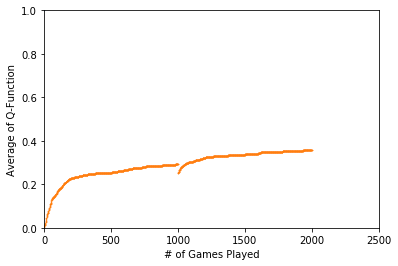

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(plot,'o',markersize=0.5)
plt.xlabel('# of Games Played')
plt.ylabel('Average of Q-Function')
plt.axis([0,2500,0,1], dotwidth=0.2)
plt.show()

## Part 2 : Asynchronous Q-Learning W/ Multiple Agents

In [2]:
from threading import Thread
from threading import Semaphore
## defining our agent as a class that can be threaded


import random
import numpy as np
import time

env = Gridworld()
A = env.actions
random.seed(41)
alpha = .2
epsilon = .5
gamma = 0.95
n_episodes = 2250
n_moves = 0
AsyncUpdate = 5


#Initialize State and Q
Q = np.zeros([env.board_length*env.board_height,len(env.actions)])
S = range(env.board_length*env.board_height)
T = 0
#make writing to global Q thread safe with Semaphore
writingQ = Semaphore(1)

class agent(Thread):
    def __init__(self,alpha, epsilon,gamma, n_episodes,S,A,env):
        Thread.__init__(self)
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_episodes=n_episodes
        self.delta_Q = np.zeros([self.env.board_length*self.env.board_height,len(self.env.actions)])
        self.S = S
        self.A = A
        self.plot = []
        self.env = env

    def run(self):
        for e in range(self.n_episodes):
            s = self.env.reset(e)
            done = False
            n_moves = 0
            while True:
                a = random.choice(self.A.keys()) if random.uniform(0,1) <= self.epsilon else np.argmax(Q[s])
                s_next, reward, done = self.env.move(a)
                self.delta_Q[s][a] =self.delta_Q[s][a] + self.alpha * ( reward + self.gamma * np.max(Q[s_next]) - Q[s][a])
                s = s_next
                
                if n_moves % AsyncUpdate == 0:
                    self.update()
                if done:
                    self.update()
                    break
                n_moves +=1
                #T += 1
            self.plot.append([e, np.mean(Q)])
    def update(self):
        writingQ.acquire()
        for i in range(54):
            for j in range(4):
                Q[i][j] = Q[i][j] + self.alpha * self.delta_Q[i][j]
        self.delta_Q = np.zeros([self.env.board_length*self.env.board_height,len(self.env.actions)])
 
        writingQ.release()



In [ ]:
a1 = agent(alpha,epsilon,gamma,n_episodes,S,A,env)
a2 = agent(alpha,epsilon,gamma,n_episodes,S,A,env)
a3 = agent(alpha,epsilon,gamma,n_episodes,S,A,env)


a1.start()
a2.start()
a3.start()

a1.join()
a2.join()
a3.join()

## Model Evaluation

- Plots of the three agents performance overtime
- Model outperforms the single agent, and does not have as dramatic of a decrease in performance after the changing board!

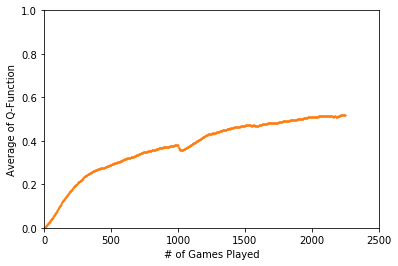

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt



plt.plot(a1.plot,'o',markersize=0.5)
plt.xlabel('# of Games Played')
plt.ylabel('Average of Q-Function')
plt.axis([0,2500,0,1], dotwidth=0.2)
plt.show()


In [15]:
env1 = Gridworld()
env2 = Gridworld()

a1_1 = agent(alpha,epsilon,gamma,n_episodes,S,A,env1)
a1_2 = agent(alpha,epsilon,gamma,n_episodes,S,A,env1)
a1_3 = agent(alpha,epsilon,gamma,n_episodes,S,A,env1)
a1_4 = agent(alpha,epsilon,gamma,n_episodes,S,A,env1)
a1_5 = agent(alpha,epsilon,gamma,n_episodes,S,A,env1)


a2_1 =agent(alpha,epsilon,gamma,n_episodes,S,A,env2)
a2_2 =agent(alpha,epsilon,gamma,n_episodes,S,A,env2)
a2_3 =agent(alpha,epsilon,gamma,n_episodes,S,A,env2)
a2_4 =agent(alpha,epsilon,gamma,n_episodes,S,A,env2)

In [16]:
Q = np.zeros([env.board_length*env.board_height,len(env.actions)])

a1_1.start()
a1_2.start()
a1_3.start()
a1_4.start()
a1_5.start()


a1_1.join()
a1_2.join()
a1_3.join()
a1_4.join()
a1_5.join()




In [17]:
Q = np.zeros([env.board_length*env.board_height,len(env.actions)])

a2_1.start()
a2_2.start()
a2_3.start()
a2_4.start()


a2_1.join()
a2_2.join()
a2_3.join()
a2_4.join()

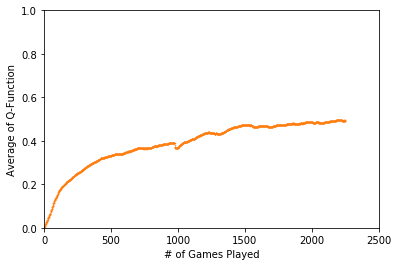

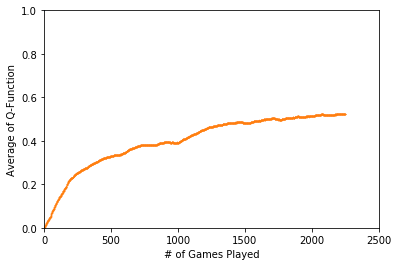

In [18]:
plt.plot(a1_1.plot,'o',markersize=0.5)
plt.xlabel('# of Games Played')
plt.ylabel('Average of Q-Function')
plt.axis([0,2500,0,1], dotwidth=0.2)
plt.show()

plt.plot(a2_1.plot,'o',markersize=0.5)
plt.xlabel('# of Games Played')
plt.ylabel('Average of Q-Function')
plt.axis([0,2500,0,1], dotwidth=0.2)
plt.show()